In [1]:
### Classification Model for text messages
#Author : Nilanjana Adlakha
#Steps followed:
#Step 1: Preprocess the text data by removing punctuations and stopwords.Also normalize the text by converting it to 
#        it's base form (lemmatize) and identify missing data if any. Since in this dataset after preprocessing only 
#        5 rows (0.1%) are left with missing entry, we remove them.
#Step 2: Split the dataset into Train and Test data making sure the proportion of classes is maintained in both the 
#        datasets.
#Step 3: Train the models and identify the best classifier for this dataset. For this dataset Naive Bayes performs well
#        with an accuracy of 98.6% and AUC Score of 0.997


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
%matplotlib inline
import matplotlib.pyplot as plt
import string
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from textblob import TextBlob
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nilanjana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing the Dataset

In [3]:
#Load dataset
df = pd.read_csv('hw_dataset.csv',encoding='utf-8')
df.head(10)

,message,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",1
6,Even my brother is not like to speak with me. They treat me like aids patent.,0
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,0
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,1
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1


In [4]:
print("Shape: ",df.shape)
print(df.label.value_counts())

Shape:  (5572, 2)
0    4825
1     747
Name: label, dtype: int64


In [5]:
#Get length of each message
df['length'] = df.message.apply(lambda x :len(x))
df.describe()

,label,length
count,5572.000000,5572.000000
mean,0.134063,80.489950
std,0.340751,59.942907
min,0.000000,2.000000
25%,0.000000,36.000000
50%,0.000000,62.000000
75%,0.000000,122.000000
max,1.000000,910.000000


In [6]:
#Checking for missing data
df[(df.message == '') | (df.message.isnull())].sum()

message    0.0
label      0.0
length     0.0
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2257eb50>]],
      dtype=object)

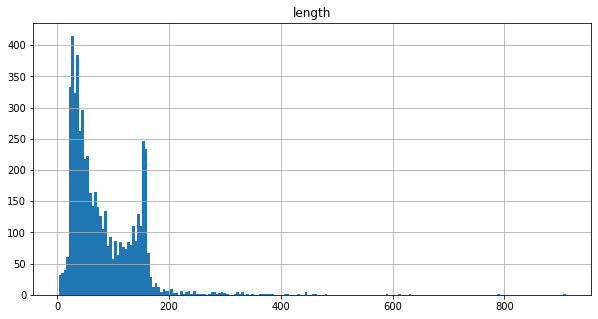

In [7]:
#Distribution of length of text
df.hist(column = 'length',bins=200,figsize=(10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b9a29d0>,
      dtype=object)

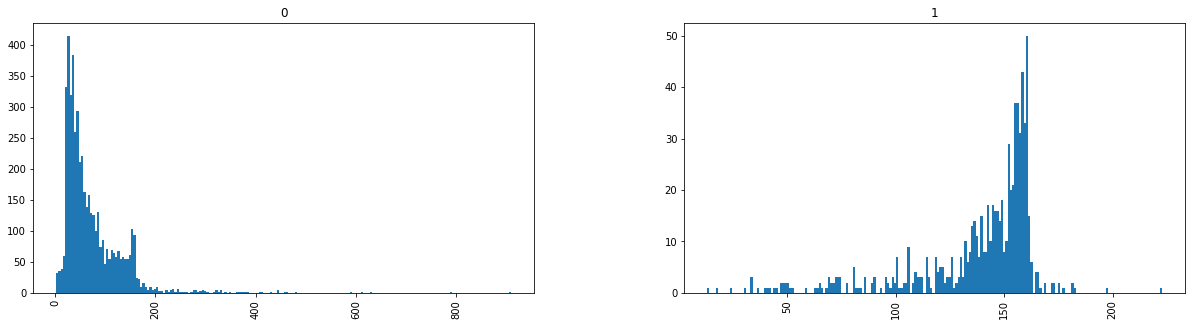

In [8]:
#Distribution of length of text by each label
df.hist(column = 'length',by='label',bins=200,figsize=(20,5))

In [9]:
#Check if a text has digits
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [10]:
df['hasNum'] = df.message.apply(lambda x:int(hasNumbers(x)))

In [11]:
print("Messages with digits:",df.hasNum.sum())
print("% Messages with digits:",str(round((df.hasNum.sum()*100)/len(df)))+"%")

Messages with digits: 1463
% Messages with digits: 26.0%


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a23a13a90>,
      dtype=object)

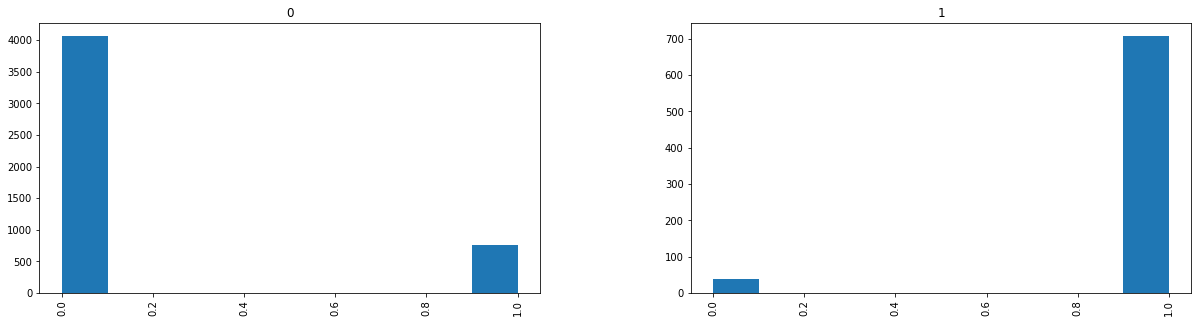

In [12]:
#Distribution of messages with digits by label
df.hist(column='hasNum',by='label',figsize=(20,5))

In [13]:
#Clean the text data - remove punctuations and stopwords
def preprocessing_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text) 

In [14]:
#normalize words into their base form lemma - Lemmatization
def lemmatize_text(text):
    words = TextBlob(text.lower()).words
    # for each word, take its "base form" 
    word = [word.lemma for word in words]
    return " ".join(word)

In [15]:
df['text'] = df.message.apply(preprocessing_text)
df['text'] = df.text.apply(lemmatize_text)

In [16]:
#Checking for missing values after preprocessing messages
print("Number of rows with missing text:",len(df[(df.text=='')]))
df[(df.text=='')]

Number of rows with missing text: 5


,message,label,length,hasNum,text
960,Where @,0,7,0,
2807,Can a not?,0,10,0,
3376,:),0,3,0,
4575,:( but your not here....,0,24,0,
4824,:-) :-),0,7,0,


In [17]:
#Dropping rows with missing data as it's only 0.1% of the dataset
df['text'].replace('', np.nan, inplace=True)
df = df.dropna(subset=['text'])
df = df.reset_index(drop=True)
df.shape

(5567, 5)

# Convert Words to Vectors

In [18]:
# Convert text to a matrix of TF-IDF features
# We take unigrams and bigrams into account to capture phrases like "Happy" vs "Very Happy" and "Happy" vs "Not Happy"
# Unigrams and Bigrams are critical in learning the semantics here
vectorizer = TfidfVectorizer(analyzer = 'word',ngram_range=(1,2))
vectors = vectorizer.fit_transform(df['text'])
vectors.shape

(5567, 40640)

# Classifcation Model

In [19]:
# Splitting into Test and Train keeping same proportion of class labels
# Independent Variable : Word Vector Matrix
# Dependent Variable: Label
X_train, X_test, y_train, y_test = train_test_split(vectors, df['label'], stratify= df['label'],test_size=0.3, random_state=10)

In [20]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(3896, 40640)
(1671, 40640)
(3896,)
(1671,)


### Comparing Models to identify the best classification model

In [21]:
#Initializing all model objects -- Naive Bayes, Logistic Regression, Support Vector Machines, Random Forest
mnb = MultinomialNB(alpha=0.25)
lr = LogisticRegression(solver='liblinear',penalty='l2')
#svm = LinearSVC()
#CalibratedClassifierCV is used to get predict_proba() from SVM model as LinearSVC() does not support the function
svm= CalibratedClassifierCV(base_estimator = LinearSVC()) 
rfc = RandomForestClassifier(n_estimators=75, random_state=111)

In [22]:
dic_mdl = {"NB":mnb,"LR":lr,"SVM":svm,"RF":rfc}

In [23]:
df_clf = pd.DataFrame()
for mdl_name,mdl in dic_mdl.items():
    mdl.fit(X_train, y_train)
    classification_rep = classification_report(mdl.predict(X_test),y_test,output_dict=True)
    accuracy = classification_rep['accuracy']
    precision_0 = classification_rep['0']['precision']
    recall_0 = classification_rep['0']['recall']
    f1_0 = classification_rep['0']['f1-score']
    precision_1 = classification_rep['1']['precision']
    recall_1 = classification_rep['1']['recall']
    f1_1 = classification_rep['1']['f1-score']
    precision = classification_rep['weighted avg']['precision']
    recall = classification_rep['weighted avg']['recall']
    f1_score = classification_rep['weighted avg']['f1-score']
    auc = metrics.roc_auc_score(y_test, mdl.predict_proba(X_test)[:,-1])
    df = pd.DataFrame([[mdl_name,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,precision,recall,f1_score,auc]])
    df_clf = df_clf.append(df)
df_clf.columns = ['Model','Accuracy','Precision_0','Recall_0','F1_Score_0','Precision_1','Recall_1','F1_Score_1','Precision','Recall','F1-Score','AUC']    

In [24]:
df_clf

,Model,Accuracy,Precision_0,Recall_0,F1_Score_0,Precision_1,Recall_1,F1_Score_1,Precision,Recall,F1-Score,AUC
0,NB,0.985637,0.995162,0.988332,0.991736,0.924107,0.967290,0.945205,0.986063,0.985637,0.985777,0.997304
0,LR,0.914423,0.999309,0.910579,0.952883,0.366071,0.987952,0.534202,0.967855,0.914423,0.932087,0.992531
0,SVM,0.982645,0.993089,0.986951,0.990010,0.915179,0.953488,0.933941,0.983065,0.982645,0.982796,0.995489
0,RF,0.967086,1.000000,0.963382,0.981350,0.754464,1.000000,0.860051,0.975167,0.967086,0.969082,0.991696


Text(0.5, 0, 'Model')

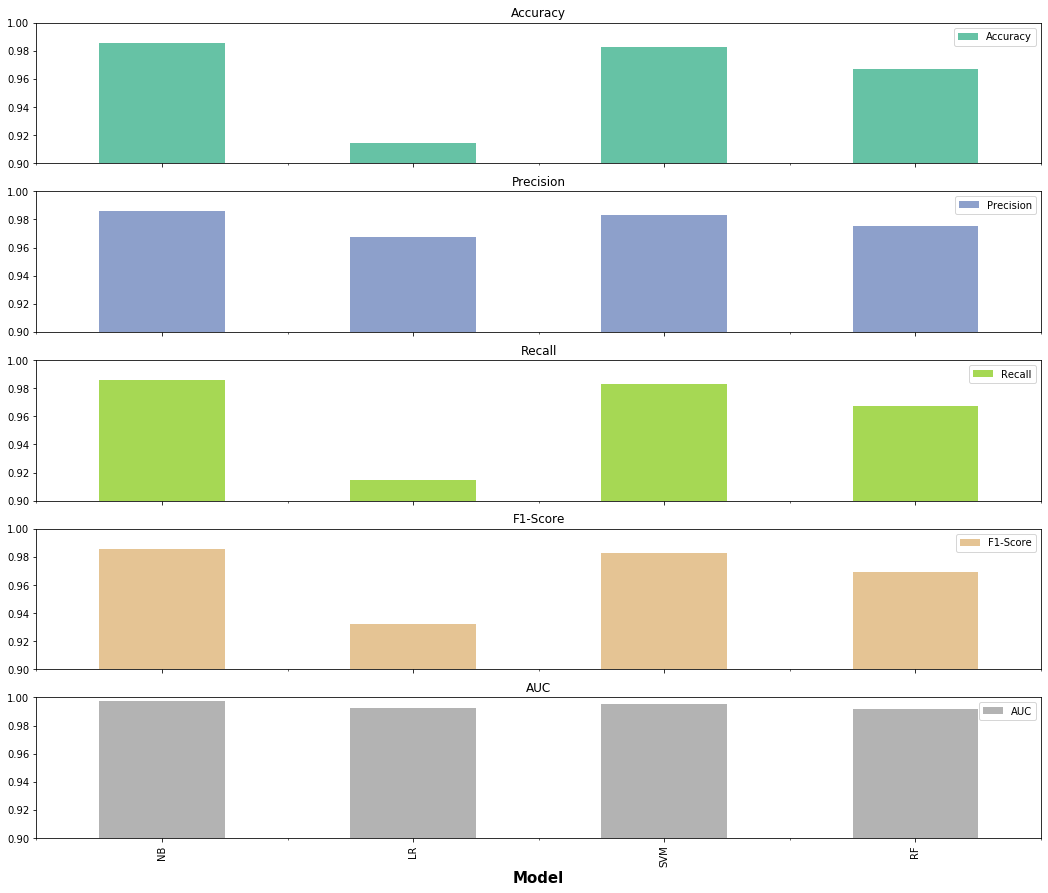

In [25]:
df_clf.plot(kind ='bar',x='Model',y=['Accuracy','Precision','Recall','F1-Score','AUC'],
            figsize=(18,15),colormap="Set2",ylim=(0.9,1.0),subplots=True)
plt.xlabel('Model',fontsize=15,fontweight='black')


# Selecting Best Classifier

In [26]:
# Since Naive Bayes performs the best of all the classifiers with an accuracy of 98.6% and high Recall and Precision
# we now use Naive Bayes to predict classes for test data
model = mnb

In [27]:
#make class predictions for X_test
y_pred_class = model.predict(X_test)
print("Accuracy Score:",metrics.accuracy_score(y_test, y_pred_class))

Accuracy Score: 0.9856373429084381


In [28]:
# print the confusion matrix
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred_class))

Confusion Matrix:
 [[1440    7]
 [  17  207]]


In [29]:
#calculate AUC
print("AUC :",metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,-1]))

AUC : 0.9973035344061605


In [30]:
#Getting Scores for test dataset
print(classification_report(model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1457
           1       0.92      0.97      0.95       214

    accuracy                           0.99      1671
   macro avg       0.96      0.98      0.97      1671
weighted avg       0.99      0.99      0.99      1671



# -------------------------------------------------------------------------------------------
# Appendix - Finding the right hyperparameters for each model

### 1. Naives Bayes

In [31]:

for c in [0.01, 0.05, 0.25, 0.5,0.75 ,1]:
    
    mnb = MultinomialNB(alpha=c)
    mnb.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, mnb.predict(X_test))
    print ("Accuracy for Test C=%s: %s" % (c, accuracy))
    print(classification_report(mnb.predict(X_test),y_test))
    print("-----------------------------------------------------------------")

Accuracy for Test C=0.01: 0.9251944943147815
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1324
           1       1.00      0.64      0.78       347

    accuracy                           0.93      1671
   macro avg       0.95      0.82      0.87      1671
weighted avg       0.93      0.93      0.92      1671

-----------------------------------------------------------------
Accuracy for Test C=0.05: 0.9521244763614602
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1369
           1       1.00      0.74      0.85       302

    accuracy                           0.95      1671
   macro avg       0.97      0.87      0.91      1671
weighted avg       0.95      0.95      0.95      1671

-----------------------------------------------------------------
Accuracy for Test C=0.25: 0.9856373429084381
              precision    recall  f1-score   support

           0       1.00 

### 2. Logistic Regression

In [32]:
for c in [0.01, 0.05, 0.25, 0.5,0.75 ,1]:
    
    lr = LogisticRegression(C=c,solver='liblinear',penalty='l2')
    lr.fit(X_train, y_train)
    print ("Accuracy for Test C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))
    print(classification_report(lr.predict(X_test),y_test))
    print("-----------------------------------------------------------------")

Accuracy for Test C=0.01: 0.8659485338120886
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1671
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1671
   macro avg       0.50      0.43      0.46      1671
weighted avg       1.00      0.87      0.93      1671

-----------------------------------------------------------------
Accuracy for Test C=0.05: 0.8659485338120886
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1671
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1671
   macro avg       0.50      0.43      0.46      1671
weighted avg       1.00      0.87      0.93      1671

-----------------------------------------------------------------
Accuracy for Test C=0.25: 0.8665469778575703
              precision    recall  f1-score   support

           0       1.00 

/Users/nilanjana/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3. Support Vector Machine

In [33]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for Test C=%s: %s"  % (c, accuracy_score(y_test, svm.predict(X_test))))
    print(classification_report(svm.predict(X_test),y_test))
    print("-----------------------------------------------------------------")

Accuracy for Test C=0.01: 0.8659485338120886
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1671
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1671
   macro avg       0.50      0.43      0.46      1671
weighted avg       1.00      0.87      0.93      1671

-----------------------------------------------------------------
Accuracy for Test C=0.05: 0.891083183722322
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1627
           1       0.19      0.98      0.32        44

    accuracy                           0.89      1671
   macro avg       0.60      0.93      0.63      1671
weighted avg       0.98      0.89      0.92      1671

-----------------------------------------------------------------
Accuracy for Test C=0.25: 0.9563135846798324
              precision    recall  f1-score   support

           0       1.00  

### 4. Random Forest

In [34]:
for c in [10,20,30,40,50,75,100]:
    rfc = RandomForestClassifier(n_estimators=c, random_state=111)
    rfc.fit(X_train, y_train)
    print ("Accuracy for Test C=%s: %s"  % (c, accuracy_score(y_test, rfc.predict(X_test))))
    print(classification_report(rfc.predict(X_test),y_test))
    print("-----------------------------------------------------------------")  

Accuracy for Test C=10: 0.9587073608617595
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1514
           1       0.70      0.99      0.82       157

    accuracy                           0.96      1671
   macro avg       0.85      0.97      0.90      1671
weighted avg       0.97      0.96      0.96      1671

-----------------------------------------------------------------
Accuracy for Test C=20: 0.9658886894075404
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1504
           1       0.75      1.00      0.85       167

    accuracy                           0.97      1671
   macro avg       0.87      0.98      0.92      1671
weighted avg       0.97      0.97      0.97      1671

-----------------------------------------------------------------
Accuracy for Test C=30: 0.9664871334530222
              precision    recall  f1-score   support

           0       1.00      0